# <center> PCA and ML

In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## data

In [4]:
data_path = "data"

In [5]:
X_train = np.load(os.path.join(data_path, "X_train.npy"))
X_test = np.load(os.path.join(data_path, "X_test.npy"))
y_train = np.load(os.path.join(data_path, "y_train.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))

In [6]:
X_train.shape, y_train.shape

((7352, 128, 9), (7352, 6))

In [7]:
X_test.shape, y_test.shape

((2947, 128, 9), (2947, 6))

In [12]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [8]:
y_train_num = y_train.argmax(1)
y_train_num

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

#### посмотрим на баланс классов

In [9]:
pd.Series(y_train_num).value_counts().sort_index()

0    1226
1    1073
2     986
3    1286
4    1374
5    1407
dtype: int64

В первом приближении классы можно считать близкими к сбалансированным

#### отделим валидационную выборку, она нам может понадобиться для подбора гиперпараметров

In [13]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train_num, test_size=0.25, 
                                                        stratify=y_train_num, random_state=17)
X_train_.shape, X_valid.shape, y_train_.shape, y_valid.shape

((5514, 1152), (1838, 1152), (5514,), (1838,))

### <center>PCA

In [15]:
sc = StandardScaler()
X_train_ = sc.fit_transform(X_train_)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [16]:
pca = PCA(n_components=0.9)
X_train_ = pca.fit_transform(X_train_)
X_valid = pca.transform(X_valid)
X_test = pca.transform(X_test)

X_train_.shape, X_valid.shape, X_test.shape

((5514, 116), (1838, 116), (2947, 116))

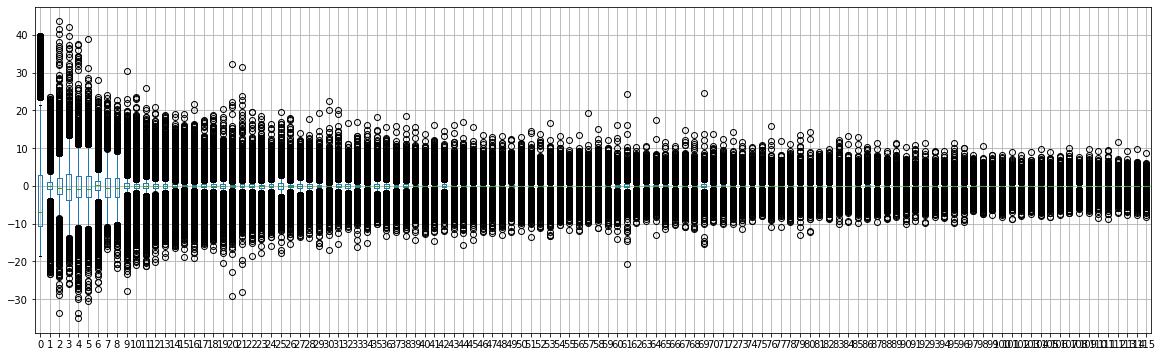

In [17]:
pd.DataFrame(X_train_).boxplot(figsize=(20, 6));

Будем использовать градиентный бустинг. Деревья не чувствительны к разбросу, поэтому вернемся к первоначальному варианту и оставим как есть

In [18]:
y_test_num = y_test.argmax(1)
y_test_num

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

## <center>ML Classification

#### Будем использовать градиентный бустинг на деревьях в качестве базовой функции, пакет XGBoost.    
В данных достаточно много естественных выбросов, распределения далеки от нормальных. Линейные классификаторы в таких условиях работают не вполне корректно, а деревья к выбросам и разным масштабам фич нечувствительны. Кроме того, деревья вполне неплохо улавливают нелинейности

In [20]:
import xgboost as xgb

In [21]:
dtrain = xgb.DMatrix(X_train_, label=y_train_)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test_num)

In [57]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softprob'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class'] = 6

In [58]:
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

In [59]:
bst = xgb.train(param, dtrain=dtrain, evals=evallist, num_boost_round=1000, early_stopping_rounds=10)

[0]	train-auc:0.90484	eval-auc:0.69720
[1]	train-auc:0.95715	eval-auc:0.67994
[2]	train-auc:0.96987	eval-auc:0.69108
[3]	train-auc:0.97851	eval-auc:0.70521
[4]	train-auc:0.98309	eval-auc:0.70589
[5]	train-auc:0.98637	eval-auc:0.70001
[6]	train-auc:0.98887	eval-auc:0.69788
[7]	train-auc:0.99052	eval-auc:0.69810
[8]	train-auc:0.99261	eval-auc:0.68845
[9]	train-auc:0.99347	eval-auc:0.68386
[10]	train-auc:0.99454	eval-auc:0.68694
[11]	train-auc:0.99527	eval-auc:0.68546
[12]	train-auc:0.99600	eval-auc:0.69652
[13]	train-auc:0.99643	eval-auc:0.69639


### Посмотрим на рейтинг важности фич (интересно же :) )

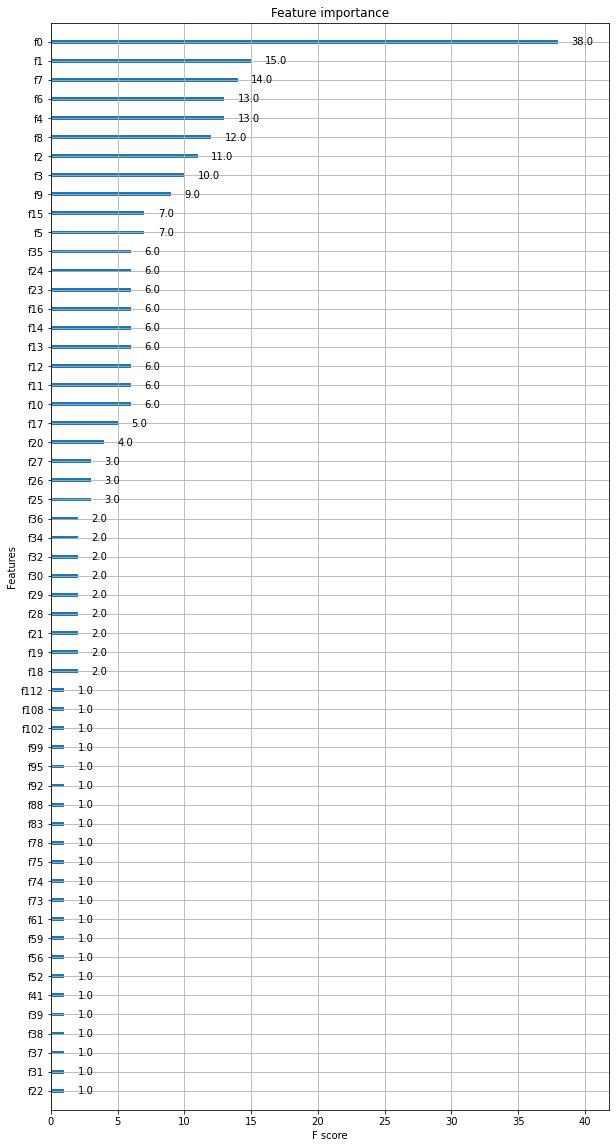

In [60]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(bst, ax=ax);

- ожидаемо, что рейтинг важности фич коррелирует с номером фичи

### Посмотрим, какие метрики получаются на тестовой выборке

In [61]:
test_predict = bst.predict(dtest)
test_predict.shape

(2947, 6)

In [62]:
test_predict_labels = test_predict.argmax(1)
test_predict_labels

array([4, 3, 3, ..., 0, 4, 3], dtype=int64)

In [63]:
precision = precision_score(y_test_num, test_predict_labels, average='micro')
recall = recall_score(y_test_num, test_predict_labels, average='micro')
roc_auc = roc_auc_score(y_test, test_predict, multi_class="ovo")
print(f"precision = {round(precision, 3)}")
print(f"recall = {round(recall, 3)}")
print(f"roc_auc = {round(roc_auc, 3)}")

precision = 0.324
recall = 0.324
roc_auc = 0.697


### Вывод:
- видим, такой подход к формированию фич не привел к хорошему результату
- оставим этот вариант в качестве ресёч и не будем рассматривать его в качестве рабочей модели